# **Fast Kmedoids Stability**

## **Requirements**

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')
from scipy import sparse
import time
import pickle
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_classification, make_blobs
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.models import FastGG, FastKmedoidsGG, KFoldFastKmedoidsGG 

## **SHARE data**

In [3]:
share_df = pl.read_csv(r"C:\Users\fscielzo\Documents\DataScience-GitHub\TFM\Data\share_df.csv")
share_df.head()

country,cchw,gender,agegroup,marriage,health,dependency,selfperceived,socio_economic,Label,WBDI_A
str,f64,i64,i64,i64,f64,f64,f64,f64,i64,f64
"""Austria""",113.109215,1,0,1,2.5,3.333,2.5,5.0,2015,2.6
"""Austria""",246.961502,1,1,2,7.5,3.333,5.0,5.0,2015,4.1
"""Austria""",623.833191,1,0,0,5.0,1.667,2.5,5.0,2015,2.3
"""Austria""",623.833191,0,0,0,2.5,0.0,0.0,3.333,2015,0.5
"""Austria""",1379.33252,1,2,1,5.0,8.333,5.0,5.0,2015,5.4


In [4]:
share_df.shape

(156628, 11)

In [5]:
variables_clustering = ['health', 'dependency', 'selfperceived', 'socio_economic', 'gender', 'agegroup', 'marriage']
share_df_wave, X_wave, Jw_wave = {}, {}, {}
for wave in share_df['Label'].unique() :
    share_df_wave[wave] = share_df.filter(pl.col('Label') == wave)
    X_wave[wave] = share_df_wave[wave][variables_clustering]

In [6]:
print(share_df_wave[2015].shape, share_df_wave[2017].shape, share_df_wave[2020].shape)

(67294, 11) (44985, 11) (44349, 11)


In [7]:
X_wave[2015].head()

health,dependency,selfperceived,socio_economic,gender,agegroup,marriage
f64,f64,f64,f64,i64,i64,i64
2.5,3.333,2.5,5.0,1,0,1
7.5,3.333,5.0,5.0,1,1,2
5.0,1.667,2.5,5.0,1,0,0
2.5,0.0,0.0,3.333,0,0,0
5.0,8.333,5.0,5.0,1,2,1


In [8]:
X_wave[2017].head()

health,dependency,selfperceived,socio_economic,gender,agegroup,marriage
f64,f64,f64,f64,i64,i64,i64
4.0,3.333,5.0,5.0,1,1,2
2.0,1.667,0.0,5.0,1,1,0
2.0,1.667,0.0,5.0,0,1,0
4.0,3.333,2.5,5.0,1,2,1
4.0,5.0,2.5,5.0,0,2,0


In [9]:
X_wave[2020].head()

health,dependency,selfperceived,socio_economic,gender,agegroup,marriage
f64,f64,f64,f64,i64,i64,i64
8.0,8.333,5.0,6.0,1,2,2
4.0,1.667,2.5,4.0,1,1,0
4.0,1.667,0.0,6.0,0,1,0
8.0,6.667,5.0,8.0,1,2,1
6.0,10.0,2.5,6.0,0,2,0


## **Sample size and stability of the classification**

In [31]:
data_sizes = [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4]
reference_size = 0.5

In [32]:
cluster_labels, times = {}, {}

for size in data_sizes + [reference_size]:
    
    fast_kmedoids = FastKmedoidsGG(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=123,
                                     frac_sample_size=size, p1=4, p2=1, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                     robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                                     VG_sample_size=1000, VG_n_samples=5)
    start_time = time.time()
    fast_kmedoids.fit(X=X_wave[2015]) 
    end_time = time.time()
    cluster_labels[size] = fast_kmedoids.labels
    times[size] = end_time - start_time
    
# Time: 29 mins

Distance matrix size: 68
Distance matrix size: 337
Distance matrix size: 673
Distance matrix size: 3365
Distance matrix size: 4711
Distance matrix size: 6730
Distance matrix size: 13459
Distance matrix size: 20189
Distance matrix size: 26918
Distance matrix size: 33647


In [35]:

with open('results/cluster_labels_stability.pkl', 'wb') as file:
    pickle.dump(cluster_labels, file)
with open('results/times_stability.pkl', 'wb') as file:
    pickle.dump(times, file)


In [36]:
with open('results/cluster_labels_stability.pkl', 'rb') as file:
    cluster_labels = pickle.load(file)
with open('results/times_stability.pkl', 'rb') as file:
    times = pickle.load(file)

In [37]:
# Adj. Rand Index with respect to the reference sample (50% of data)
adj_rand_index_values = [adjusted_rand_score(labels_true=cluster_labels[reference_size], labels_pred=cluster_labels[size]) for size in data_sizes if size != reference_size]
prop_similarity_values = [np.mean(cluster_labels[reference_size] == cluster_labels[size]) for size in data_sizes if size != reference_size]
data_sizes_test = np.array([x for x in data_sizes if x != reference_size])
times_test = np.array([times[x] for x in times.keys() if x != reference_size])
data_sizes_perc_reference = np.round((np.array(data_sizes_test) / reference_size)*100, 2)

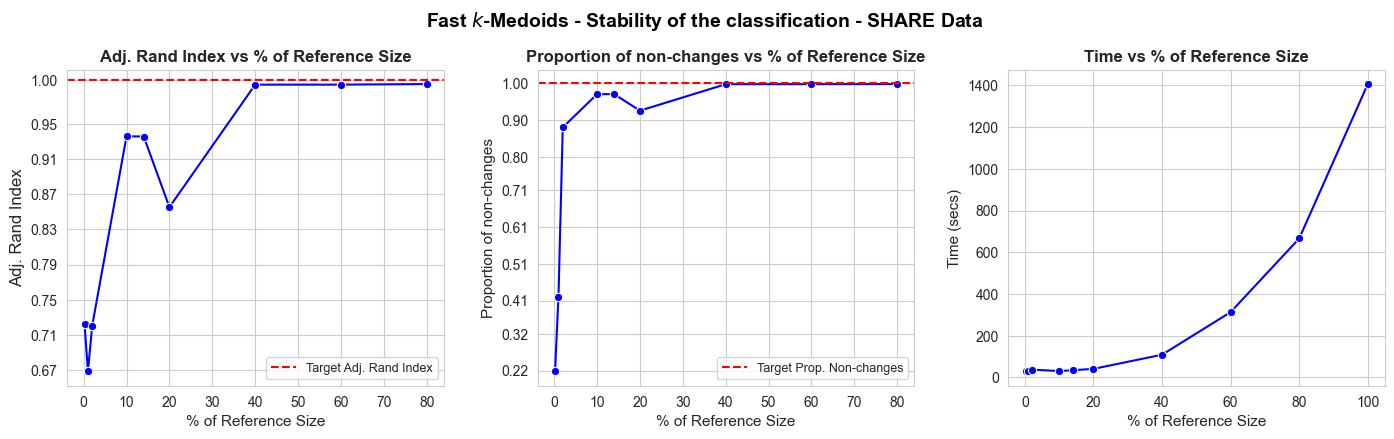

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
axes = axes.flatten()  

sns.lineplot(x=data_sizes_perc_reference, y=adj_rand_index_values, color='blue', marker='o', markersize=6, ax=axes[0])
sns.lineplot(x=data_sizes_perc_reference, y=prop_similarity_values, color='blue', marker='o', markersize=6, ax=axes[1])
sns.lineplot(x=data_sizes_perc_reference.tolist() + [100], y=times.values(), color='blue', marker='o', markersize=6, ax=axes[2])

axes[0].axhline(y=1, color='red', linestyle='--', label='Target Adj. Rand Index')
axes[0].set_title('Adj. Rand Index vs % of Reference Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Rand Index', size=12, rotation=90)
y_min = np.min(adj_rand_index_values)
y_max = np.max(adj_rand_index_values)
axes[0].set_yticks(np.round(np.linspace(y_min, y_max, 9), 2))    

axes[1].axhline(y=1, color='red', linestyle='--', label='Target Prop. Non-changes')
axes[1].set_title('Proportion of non-changes vs % of Reference Size', size=12, weight='bold')
axes[1].set_ylabel('Proportion of non-changes', size=11, rotation=90)
y_min = np.min(prop_similarity_values)
y_max = np.max(prop_similarity_values)
axes[1].set_yticks(np.round(np.linspace(y_min, y_max, 9), 2))    

axes[2].set_title('Time vs % of Reference Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11, rotation=90)

for i in range(len(axes)):
    if i < 2:
        axes[i].legend(fontsize=9)
    axes[i].set_xlabel('% of Reference Size', size=11, rotation=0)

#plt.tight_layout()
plt.suptitle('Fast $k$-Medoids - Stability of the classification - SHARE Data', fontsize=14, y=1.05, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.25, top=0.9) 

file_name = 'plots/kmedoids_stability'
fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [39]:
data_sizes_perc_reference

array([ 0.2,  1. ,  2. , 10. , 14. , 20. , 40. , 60. , 80. ])